## Hardware Setup <a class="anchor" id="hardware-setup"></a>

The RFSoC2x2 board is dual-channel. Notice that there are only
4 SMAs on your board, labeled DAC1, DAC2, ADC1, and ADC2.
Only two sets of RF ADC and RF DAC channels are accessible on
the RFSoC2x2 board.

You should create the loopback connection using SMA cables
as shown below:

* Channel 0: DAC2 to ADC2
* Channel 1: DAC1 to ADC1

See the image below for a demonstration.

<img src='data/rfsoc2x2_connections.jpg' align='left' style='left' width='40%' height='40%'/>

In [1]:
import time
import xrfdc
from pynq import allocate
import matplotlib.pyplot as plt
from pynq.overlays.base import BaseOverlay
base = BaseOverlay('lteCellSearch_v1.6.bit')

The RFSoC2x2 has a sophisticated clocking network, which can generate
low-jitter clocks for the RF DC Phase-Locked Loops (PLLs). The base overlay
has a simple method to initialize these clocks. Run the cell below to set
the LMK and LMX clocks to 122.88MHz and 491.52MHz, respectively.

In [2]:
base.init_rf_clks(lmk_freq=122.88, lmx_freq=491.52)

In [3]:
base.radio.transmitter.channel_00.dac_tile.DynamicPLLConfig(1, 491.52, 3932.16)
base.radio.transmitter.channel_10.dac_tile.DynamicPLLConfig(1, 491.52, 3932.16)
base.radio.receiver.channel_00.adc_tile.DynamicPLLConfig(1, 491.52, 3932.16)
base.radio.receiver.channel_20.adc_tile.DynamicPLLConfig(1, 491.52, 3932.16)

### Setting up the Transmitter
There are several interesting spectral properties to inspect.
We will set up each RF DAC channel with a carrier frequency first.
Then we can set the each channel to different frequencies and amplitudes
to make our example more interesting.

In [4]:
def set_transmitter_channel(channel, enable, gain, frequency):
    channel.control.enable = enable
    channel.control.gain = gain
    channel.dac_block.MixerSettings['Freq'] = frequency

set_transmitter_channel(base.radio.transmitter.channel[0], True, 0.8, 800)
set_transmitter_channel(base.radio.transmitter.channel[1], True, 0.8, 800)

The above code cell has set the transmitter for each channel as follows:

* Transmitter Channel 0
    * Frequency: 200 MHz
    * Gain: 0.8
* Transmitter Channel 1
    * Frequency: 1500 MHz
    * Gain: 0.15
    
Lets look out for these frequencies when we finally reach the spectrum analysis section.

### Capture RF ADC Data <a class="anchor" id="capture-rf-adc-data"></a>

In order to perform spectral analysis, we need to capture data from the RF
ADC. We can capture data using the radio hierarchy block.

In [5]:
base.radio.receiver.channel_00.adc_block.MixerSettings['Freq'] = -800.0
base.radio.receiver.channel_20.adc_block.MixerSettings['Freq'] = -800.0

In [6]:
base.radio.receiver.channel_00.adc_block.UpdateEvent(xrfdc.EVENT_MIXER)
base.radio.receiver.channel_20.adc_block.UpdateEvent(xrfdc.EVENT_MIXER)
base.radio.transmitter.channel_00.dac_block.UpdateEvent(xrfdc.EVENT_MIXER)
base.radio.transmitter.channel_10.dac_block.UpdateEvent(xrfdc.EVENT_MIXER)

In [7]:
number_samples = 4096
sample_frequency = 491.52e6
cdata = []
for i in range(0, len(base.radio.receiver.channel)):
    cdata.append(base.radio.receiver.channel[i].transfer(number_samples))

Great, let's now create time domain plots for each segment of data captured
from the RF ADC. 

In the cell below, we have created a simple helper function `plot_complex_time`
which can help us quickly create new complex time domain plots. 
We will use `plotly`, `numpy`, and `ipywidgets` to support our visualization.

In [8]:
import plotly.graph_objs as go
import numpy as np
import ipywidgets as ipw

def plot_complex_time(data, n=number_samples, fs=sample_frequency, 
                      title='Complex Time Plot'):
    plt_re_temp = (go.Scatter(x = np.arange(0, n/fs, 1/fs),
                              y = np.real(data), name='Real'))
    plt_im_temp = (go.Scatter(x = np.arange(0, n/fs, 1/fs),
                              y = np.imag(data), name='Imag'))
    return go.FigureWidget(data = [plt_re_temp, plt_im_temp],
                           layout = {'title': title, 
                                     'xaxis': {
                                         'title': 'Seconds (s)',
                                         'autorange' : True},
                                     'yaxis': {
                                         'title': 'Amplitude (V)'}})

tfigs = []
for i in range(0, len(base.radio.receiver.channel)):
    tfigs.append(plot_complex_time(
            data=cdata[i], 
            title=''.join(['Time Domain Plot of ADC Channel ', str(i)])))

ipw.VBox(tfigs)

    'data': [{'name': 'Real',
              'type': 'scatter',
              'ui…

Note it is quite difficult to look at the plots and determine the signal's
oscillation frequency. This is where spectral analysis can prove to be very
useful. Let's first apply a simple window to our time domain signals.

### Time Domain Windowing <a class="anchor" id="time-domain-windowing"></a>

Windowing is a useful tool in spectral analysis of a time domain signal. 
This technique is used on the time domain signal before FFT. 

Why do we need windowing? The FFT assumes that the input signal is periodic.
To prevent unwanted frequency spurs and spectral leakage, the start of the
signal should also connect to the end of the signal.

In this example, we will use a simple Blackman
filter to illustrate windowing.

In [9]:
window = np.array(np.blackman(number_samples)[:])

The blackman window can be easily applied to the time domain data
through element-wise multiplication. This is why the window created in the
cell above, is the same size as our time domain data.

In [10]:
wdata = []
wfigs = []

for i in range(0, len(base.radio.receiver.channel)):
    wdata.append(cdata[i]*window)
    wfigs.append(plot_complex_time(
            data=wdata[i], 
            title=''.join(['Windowed Plot of ADC Channel ', str(i)])))

ipw.VBox(wfigs)

    'data': [{'name': 'Real',
              'type': 'scatter',
              'ui…

As you can see, the windowed data now starts and ends around an amplitude of 0.
This reduces spectral leakage and unwanted spurs when we later perform
spectral analysis.

### Convert to the Frequency Domain <a class="anchor" id="convert-to-the-frequency-domain"></a>

Converting to the frequency domain is very easy using the FFT. The `numpy`
package performs most of the hard work for us. Let's obtain the magnitude of
the frequency spectrum.

In [11]:
fdata = []
for i in range(0, len(base.radio.receiver.channel)):
    fdata.append(np.fft.fftshift(np.fft.fft(wdata[i])))

The FFT algorithm will always return the positive and
negative frequencies in reverse order. So we should swap these around
using `np.fft.fftshift` as given in the above cell. 

After shifting the frequency spectrum, we can plot to inspect the results.

In [12]:
def plot_complex_spectrum(data, N=number_samples, fs=sample_frequency, 
                          title='Complex Spectrum Plot', units='dBW', fc=0):
    plt_temp = (go.Scatter(x = np.arange(-fs/2, fs/2, fs/N) + fc,
                           y = data, name='Spectrum'))
    return go.FigureWidget(data = plt_temp,
                           layout = {'title': title, 
                                     'xaxis': {
                                         'title': 'Frequency (Hz)',
                                         'autorange': True},
                                     'yaxis': {
                                         'title': units}})

magfigs = []
for i in range(len(base.radio.receiver.channel)):
    magfigs.append(plot_complex_spectrum(
            data=abs(fdata[i]),
            title=''.join(['Frequency Magnitude Plot of ADC Channel ', str(i)]),
            units='|Y(f)|',
            fc=0))

ipw.VBox(magfigs)

    'data': [{'name': 'Spectrum',
              'type': 'scatter',
             …

The code cell above introduced a new custom function `plot_complex_spectrum`
to help us plot complex frequency domain plots. This function has an optional
argument `fc` to shift the plot's x-axis around the RF ADC block center frequency.

Inspecting the plots, you will see a peak around 200 MHz on channel 0, 
and 1500 MHz on channel 1. Notice the power of the signal for each channel.

In [13]:
def freq_to_psd(data, N=number_samples, fs=sample_frequency, 
                window=np.array(np.ones(number_samples)[:])):
    psd = (abs(data)**2)/(fs*np.sum(window**2))
    return 10*np.where(psd > 0, np.log10(psd), 0)

psd = []
for i in range(0, len(base.radio.receiver.channel)):
    psd.append(freq_to_psd(data=fdata[i], window=window))

### Plotting the Spectrum <a class="anchor" id="plotting-the-spectrum"></a>

Finally, we can do the frequency plots. We will plot the PSD similar to
before and inspect the spectrum for each channel.

In [14]:
psdfigs = []
for i in range(0, len(base.radio.receiver.channel)):
    psdfigs.append(plot_complex_spectrum(
            data=psd[i],
            title=''.join(['Power Spectral Density Plot of ADC Channel ',
                           str(i)]),
            units='dB',
            fc=0))

ipw.VBox(psdfigs)

    'data': [{'name': 'Spectrum',
              'type': 'scatter',
             …

You will be able to see the peaks of each tone that was generated from the RF
DAC for each channel. Channel 0 was 200 MHz and channel 1 was 1500 MHz. 

In [15]:
matlabIP  = base.radio.receiver.channel_00.LTE_MIB_H_ip_0
vitisIP   = base.radio.receiver.channel_20.lteCellSearch_0
matlabTx0 = base.radio.transmitter.channel_00.LTE_GENER_ip_0
matlabTx1 = base.radio.transmitter.channel_10.LTE_GENER_ip_0
matlabDec = base.radio.receiver.channel_20.LTE_DOWNS_ip_0

In [16]:
matlabTx0.write(0x100,1)
matlabTx1.write(0x100,1)
matlabDec.write(0x100,1)

In [17]:
matlabIP.write(0x100,0x1) #extdatasel_in
time.sleep(0.1)

matlabIP.write(0x108,0x1) #start_in : Start ON
time.sleep(0.1)

matlabIP.write(0x108,0x0) #start_in : Start OFF
time.sleep(0.1)

In [18]:
val = matlabIP.read(0x100) #extdatasel_in_Data
print("Ext Data Select 0x%X : " % val)
val = matlabIP.read(0x108) # start_in_Data
print("Start 0x%X : " % val)
val = matlabIP.read(0x110) #ncellid_Data
print("NCell ID 0x%X : " % val)
val = matlabIP.read(0x118) #freqest_Data
print("Freq Est. 0x%X : " % val)
val = matlabIP.read(0x11C) #celldetected_Data
print("Cell Detected 0x%X : " % val)
val = matlabIP.read(0x120) #cellsearchdone_Data
print("Cell Search Done 0x%X : " % val)
val = matlabIP.read(0x138) #mibdetected_Data
print("MIB Detected 0x%X : " % val)
val = matlabIP.read(0x13C) #miberror_Data
print("MIB Error 0x%X : " % val)

Ext Data Select 0x1 : 
Start 0x0 : 
NCell ID 0x65 : 
Freq Est. 0xFFFFFFFE : 
Cell Detected 0x1 : 
Cell Search Done 0x1 : 
MIB Detected 0x1 : 
MIB Error 0x0 : 


In [19]:
for _ in range(0,10):
    matlabIP.write(0x100,0x1) #extdatasel_in
    time.sleep(0.1)
    matlabIP.write(0x108,0x1) #start_in : Start ON
    time.sleep(0.1)
    matlabIP.write(0x108,0x0) #start_in : Start OFF
    time.sleep(0.5)
    
    val1 = matlabIP.read(0x110) #ncellid_Data
    val2 = matlabIP.read(0x118) #freqest_Data
    print("Freq Est. %08X \t NCell ID %03d" % (val2,val1), end='\r')

    time.sleep(1)

In [20]:
NUM_DATA = 1024
out_debug = allocate(shape=(NUM_DATA,), dtype=np.int32) 
vitisIP.write(0x20, out_debug.device_address) # Map Debug Output

In [26]:
vitisIP.write(0x00, 0x01) # Restart IP
time.sleep(0.5)
val = vitisIP.read(0x10) #Data signal of OUT_F
print("Freq Est OUT_F %012.3F" % (val/1000.0), end='\r')

In [22]:
for _ in range(0,10):
    vitisIP.write(0x00, 0x01) # Restart IP
    time.sleep(0.5)
    val = vitisIP.read(0x10) #Data signal of OUT_F
    print("Freq Est OUT_F %012.3F" % (val/1000.0), end='\r')
    time.sleep(1)

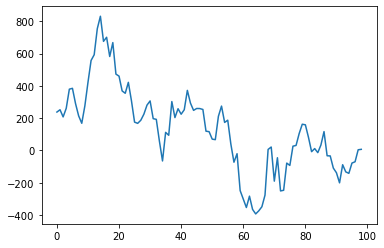

In [23]:
""" Plotting FreqEst Debug Data """
%matplotlib inline
plt.plot(out_debug[1:100]/1000.0)
plt.show()